# Supply Chain EDA (full EDA with analysis available in pdf)
> **This file is temporary (will create python file for visualization and outcomes)** 😉

In this notebook we will take a dive into the costs and profits of all our orders. We will see, which products are the most profitable and which ones should, perhaps, be taken of the list.   
Among others, we will see:
- which product categories are ordered most often;
- which product categories are most often cancelled or possibly fraudulant;
- which products in each category bring in the most and the least profit;
- how do the customers types differ in the things they order;
- on which categories and which products is the company losing the most;
- what are the most and least expensive products;
- which categories are the most and least expensive, and averages, distribution of prices, kurtosis;
- which categories are the most discounted ones;
- how many sales are made per customer and sales total per customer;
- do small customer clustering via their buying patterns and PCA;
- if there are any trends in the order time and dates;
- if there is any weekly pattern in the shipement;
- many others ;)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from datetime import datetime
import pickle

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

with open('data/supply_chain_dictionaties.pkl', 'rb') as file:
    dictionaries = pickle.load(file)

product_name = dictionaries[0]
department_name = dictionaries[1]
category_name = dictionaries[2]

In [65]:
df = pd.read_parquet('data/SupplyChainDataset_cleaned.parquet')
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Department Id,Market,Order Country,Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order Status,Product Card Id,Product Price,Shipping Mode,Shipping date,Order date,Order time,Order day,Shipping time,Shipping day,Target shipping days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,México,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01 00:00:00,2015-01-01 00:00:00,2015-01-01 00:00:00,Thursday,2015-03-01 00:00:00,Sunday,-2
1,PAYMENT,36.47,107.89,0,18,Chicago,United States,256,Consumer,IL,4,LATAM,Colombia,2,22.10,0.17,4,0.34,1,129.99,South America,PENDING_PAYMENT,403,129.99,Standard Class,2015-04-01 00:21:00,2015-01-01 00:21:00,2015-01-01 00:21:00,Thursday,2015-04-01 00:21:00,Wednesday,-1
2,PAYMENT,91.18,193.99,0,48,Chicago,United States,256,Consumer,IL,7,LATAM,Colombia,2,6.00,0.03,2,0.47,1,199.99,South America,PENDING_PAYMENT,1073,199.99,Standard Class,2015-04-01 00:21:00,2015-01-01 00:21:00,2015-01-01 00:21:00,Thursday,2015-04-01 00:21:00,Wednesday,-1
3,PAYMENT,68.25,227.50,0,24,Chicago,United States,256,Consumer,IL,5,LATAM,Colombia,2,22.50,0.09,3,0.30,5,250.00,South America,PENDING_PAYMENT,502,50.00,Standard Class,2015-04-01 00:21:00,2015-01-01 00:21:00,2015-01-01 00:21:00,Thursday,2015-04-01 00:21:00,Wednesday,-1
4,PAYMENT,19.80,90.00,1,24,Conway,United States,10039,Consumer,AR,5,LATAM,Honduras,30,10.00,0.10,88,0.22,2,100.00,Central America,PENDING_PAYMENT,502,50.00,Standard Class,2015-07-01 10:09:00,2015-01-01 10:09:00,2015-01-01 10:09:00,Thursday,2015-07-01 10:09:00,Wednesday,2


In [66]:
df['Order time'] = df['Order date'].dt.time
df['Shipping time'] = df['Shipping date'].dt.time
df['Shipping date'] = df['Shipping date'].dt.date
df['Order date'] = df['Order date'].dt.date
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Department Id,Market,Order Country,Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order Status,Product Card Id,Product Price,Shipping Mode,Shipping date,Order date,Order time,Order day,Shipping time,Shipping day,Target shipping days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,México,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01,2015-01-01,00:00:00,Thursday,00:00:00,Sunday,-2
1,PAYMENT,36.47,107.89,0,18,Chicago,United States,256,Consumer,IL,4,LATAM,Colombia,2,22.10,0.17,4,0.34,1,129.99,South America,PENDING_PAYMENT,403,129.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
2,PAYMENT,91.18,193.99,0,48,Chicago,United States,256,Consumer,IL,7,LATAM,Colombia,2,6.00,0.03,2,0.47,1,199.99,South America,PENDING_PAYMENT,1073,199.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
3,PAYMENT,68.25,227.50,0,24,Chicago,United States,256,Consumer,IL,5,LATAM,Colombia,2,22.50,0.09,3,0.30,5,250.00,South America,PENDING_PAYMENT,502,50.00,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
4,PAYMENT,19.80,90.00,1,24,Conway,United States,10039,Consumer,AR,5,LATAM,Honduras,30,10.00,0.10,88,0.22,2,100.00,Central America,PENDING_PAYMENT,502,50.00,Standard Class,2015-07-01,2015-01-01,10:09:00,Thursday,10:09:00,Wednesday,2


In [4]:
df.describe()

,Benefit per order,Sales per customer,Late_delivery_risk,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Product Price,Target shipping days
count,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00
mean,21.97,183.11,0.55,20.66,0.10,0.12,2.13,203.77,141.23,0.57
std,104.43,120.04,0.50,21.80,0.07,0.47,1.45,132.27,139.73,1.49
min,-4274.98,7.49,0.00,0.00,0.00,-2.75,1.00,9.99,9.99,-2.00
25%,7.00,104.38,0.00,5.40,0.04,0.08,1.00,119.98,50.00,0.00
50%,31.52,163.99,1.00,14.00,0.10,0.27,1.00,199.92,59.99,1.00
75%,64.80,247.40,1.00,29.99,0.16,0.36,3.00,299.95,199.99,1.00
max,911.80,1939.99,1.00,500.00,0.25,0.50,5.00,1999.99,1999.99,4.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Type                      180519 non-null  category
 1   Benefit per order         180519 non-null  float64 
 2   Sales per customer        180519 non-null  float64 
 3   Late_delivery_risk        180519 non-null  int64   
 4   Category Id               180519 non-null  category
 5   Customer City             180519 non-null  object  
 6   Customer Country          180519 non-null  category
 7   Customer Id               180519 non-null  category
 8   Customer Segment          180519 non-null  category
 9   Customer State            180519 non-null  object  
 10  Department Id             180519 non-null  category
 11  Market                    180519 non-null  category
 12  Order Country             180519 non-null  object  
 13  Order date                180

In [6]:
df.isnull().sum().sum() # no missing values

0

In [7]:
df.duplicated().sum()

0

In [8]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
continous_columns = ['Benefit per order', 'Sales per customer','Order Item Discount',
                     'Order Item Profit Ratio', 'Sales', 'Product Price']

In [9]:
def extended_statistics(dataframe, columns):
    es = pd.DataFrame({'Mean': dataframe[columns].mean(),
                       'Standard deviation': dataframe[columns].std(),
                       'Median': dataframe[columns].median(),
                       'Sum': [dataframe[c].sum() for c in columns],
                       'Skewness': [skew(dataframe[c]) for c in columns],
                       'Kurtosis': [kurtosis(dataframe[c]) for c in columns],
                       'Outliers count': [len(outliers(dataframe, c)[0]) for c in columns],
                      'Lower bound': [outliers(dataframe, c)[1] for c in columns],
                      'Upper bound': [outliers(dataframe, c)[2] for c in columns]})

    return es.T

In [10]:
def outliers(dataframe, column):
    outliers = []
    q1 = np.percentile(sorted(dataframe[column]), 25)
    q3 = np.percentile(sorted(dataframe[column]), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in sorted(dataframe[column]): 
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound


In [11]:
extended_statistics(df, numeric_columns)

,Benefit per order,Sales per customer,Late_delivery_risk,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Product Price,Target shipping days
Mean,21.97,183.11,0.55,20.66,0.10,0.12,2.13,203.77,141.23,0.57
Standard deviation,104.43,120.04,0.50,21.80,0.07,0.47,1.45,132.27,139.73,1.49
Median,31.52,163.99,1.00,14.00,0.10,0.27,1.00,199.92,59.99,1.00
Sum,3966902.97,33054402.04,98977.00,3730378.40,18353.04,21779.01,384079.00,36784735.01,25495158.68,102139.00
Skewness,-4.74,2.89,-0.19,3.04,0.34,-2.89,0.88,2.88,3.19,0.03
Kurtosis,71.38,23.92,-1.96,25.23,-0.90,10.16,-0.75,23.94,23.31,-0.29
Outliers count,18942.00,1943.00,0.00,7537.00,0.00,17300.00,0.00,488.00,2048.00,35701.00
Lower bound,-79.70,-110.15,-1.50,-31.48,-0.14,-0.34,-2.00,-149.98,-174.99,-1.50
Upper bound,151.50,461.93,2.50,66.87,0.34,0.78,6.00,569.91,424.98,2.50


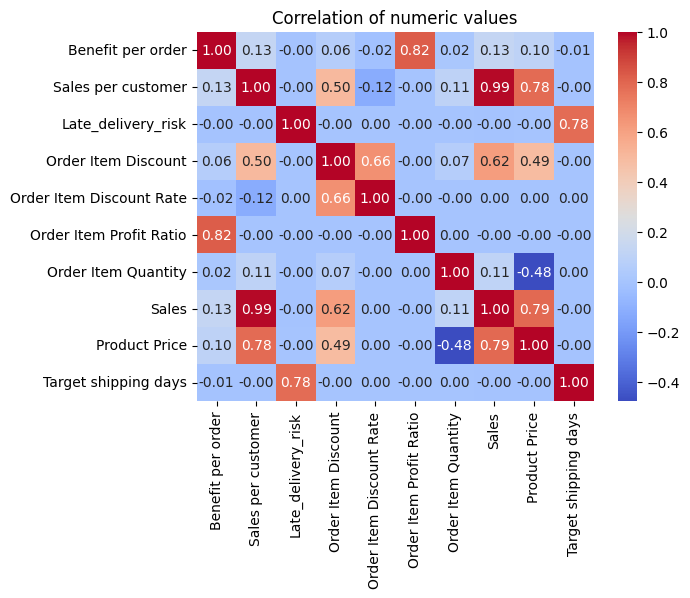

In [96]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=',.2f')
plt.title('Correlation of numeric values')
plt.savefig(f'graphs/Correlogram_of_nmeric_values.png')

plt.show()

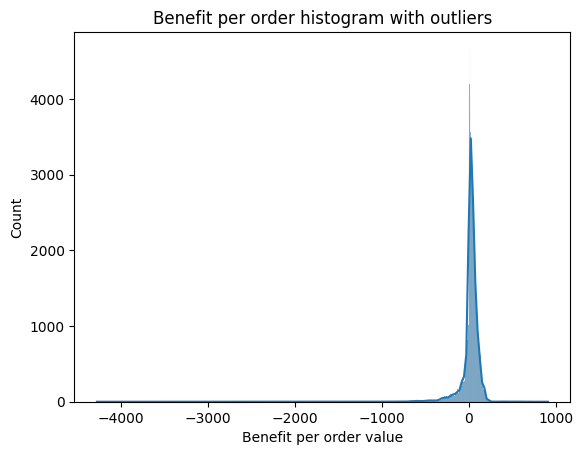

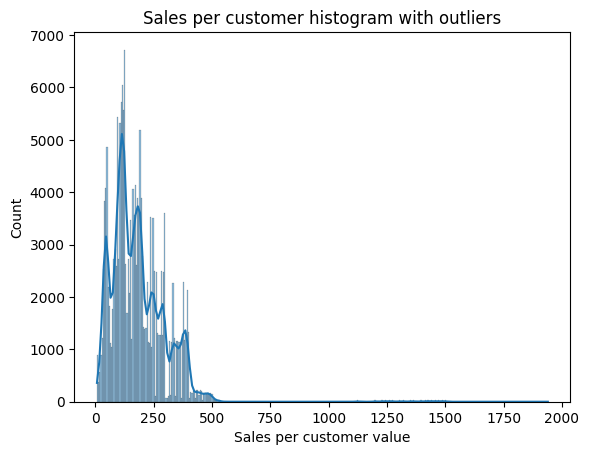

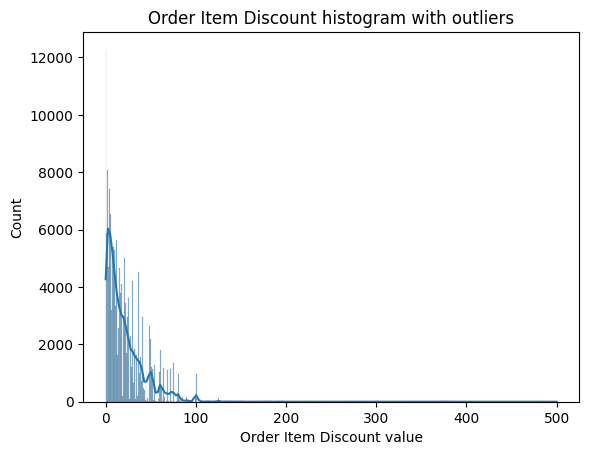

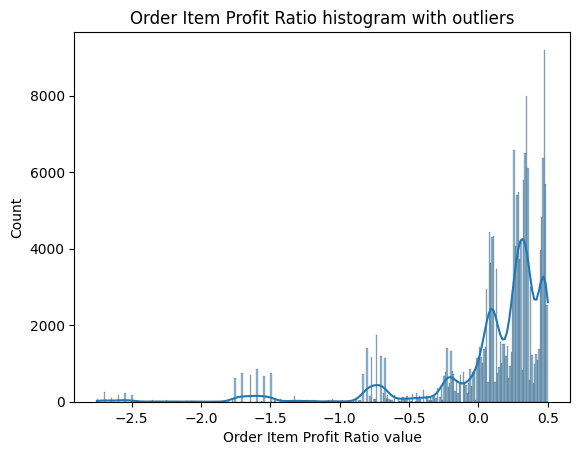

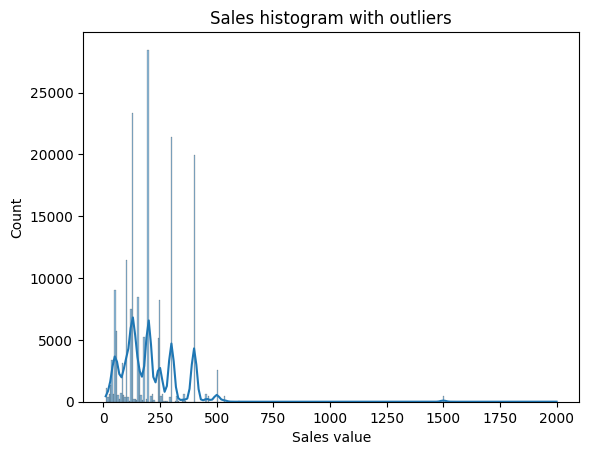

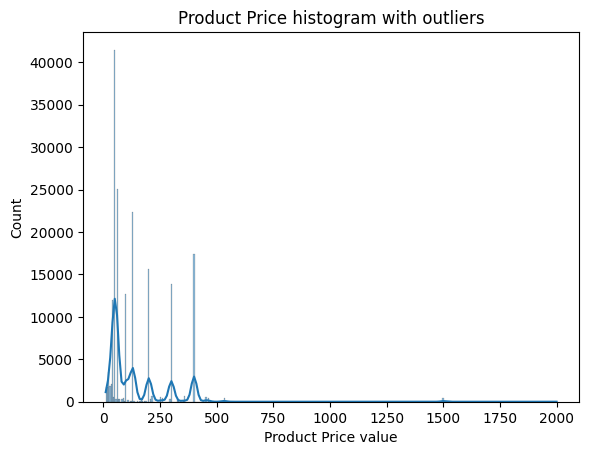

In [18]:
for c in continous_columns:
    sns.histplot(data=df, x=c, kde=True) # kde is our line representation of histogram
    plt.title(f'{c} histogram with outliers')
    plt.xlabel(f'{c} value')
    plt.ylabel('Count')
    ax = plt.gca()
    plt.savefig(f'graphs/histograms/{c}_histogram_with_outliers.png')
    plt.show()

Outliers in this dataset should not be deleted or replaced, as these are calculated correctly - our store has a few more pricey items, hence some of the higher sales, and since not all items in the store are profitable, we notice the negative benefits or profit ratios. These outliers give us a great information, at where we are losing money in the supply chain, since the benefits are greatly negative in those instances.

However, those orders are minority. I will create an additional dataset to get the look at majority of the data and then compare the majority distribution with the one with outliers. Later on in the analysis, we will take a look at those outliers to analyse, which products should be withdrawn from the offer, to avoid further losses.

In [19]:
outliers_in_columns = {}
for c in continous_columns:
    outliers_in_columns[c] = outliers(df, c)[0]

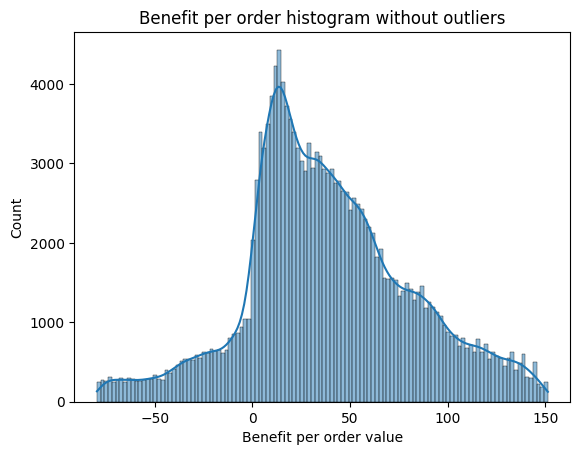

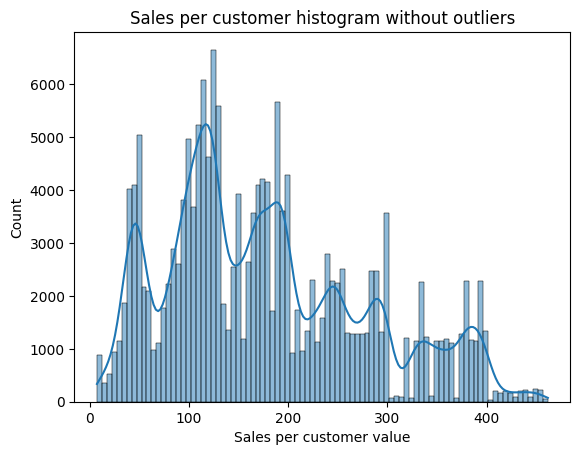

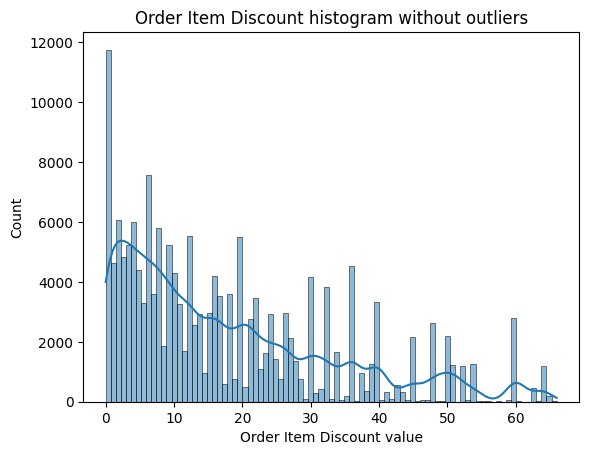

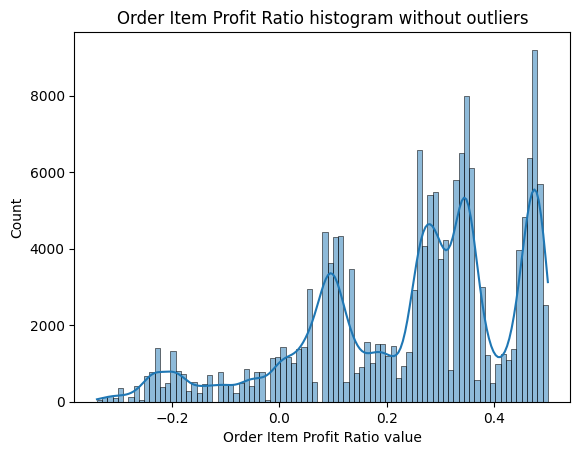

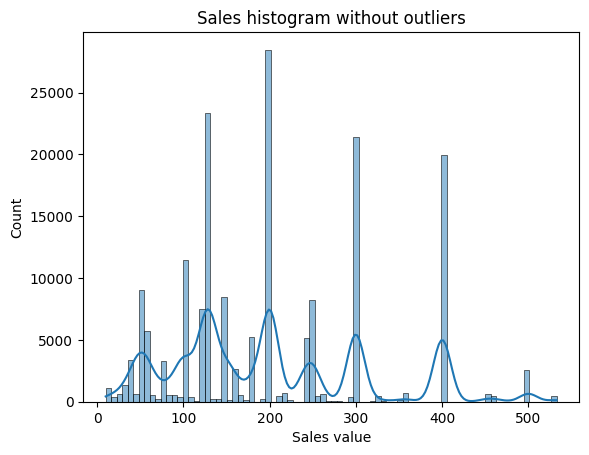

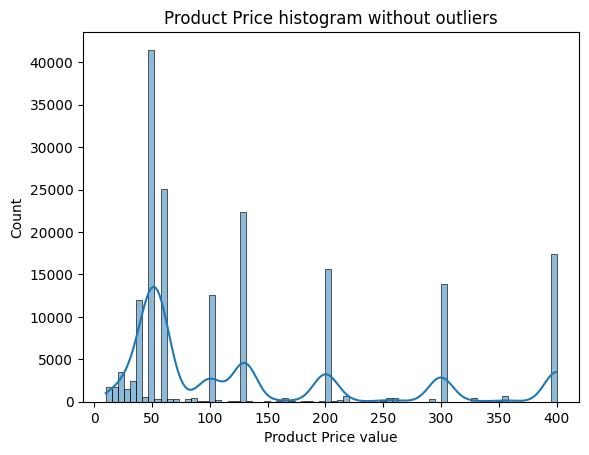

In [25]:
for c in continous_columns:
    filtered_df = df.drop(df[df[c].isin(outliers_in_columns[c])].index)
    sns.histplot(data=filtered_df, x=c, kde=True) # kde is our line representation of histogram
    plt.title(f'{c} histogram without outliers')
    plt.xlabel(f'{c} value')
    plt.ylabel('Count')
    ax = plt.gca()
    plt.savefig(f'graphs/histograms/{c}_histogram_without_outliers.png')
    plt.show()

**zlicz wszystkie wartości kategorii**
`df['name'].value_counts(ascending=False)`

może zbierz te, które mają mniejsze wartości niż ileś (średnia?) jako inne
`df[].apply(funkcja)`

jak znajdziesz ile zamawia się jakich produktów, wskaż top 5 i najgorsze 5 pod względem zysków i częstości wybierania
(pewnie da się to zrobić przez group by średnią albo count?)

pousuwać outliersy ale gdy zliczymy zamówienia? czy nje?

korelogram

zyski odnotowane ze sprzedaży na dzień, dla szeregu czasowego (to przy szeregach) 
lub liczba zamówień, albo oba

sprawdzić błądzenie losowe i whitenoise dla szeregu czasowego (zyski lub liczba zamówień)

czy są jakieś przesłanki dla opóźnionej wysyłki?
(klastrowanie?)

ABC analysis??co to??

## Zliczenie zamówień dla danych kategorycznych

In [101]:
def count_orders(dataframe, column, dictionary=None):
    orders = dataframe[column].value_counts(ascending=False)
    if dictionary is not None:
        orders.index = orders.index.map(dictionary)
    return orders

def count_items_ordered(dataframe, column, dictionary=None):
    items = dataframe.groupby(column)['Order Item Quantity'].sum().sort_values(ascending=False)
    if dictionary != None:
        items.index = items.index.map(dictionary)
    return items

In [68]:
product_orders = count_orders(df, 'Product Card Id', product_name)
product_items_ordered = count_items_ordered(df, 'Product Card Id', product_name)

categories_orders = count_orders(df, 'Category Id', category_name)
categories_items_ordered = count_items_ordered(df, 'Category Id', category_name)

department_orders = count_orders(df, 'Department Id', department_name)
department_items_ordered = count_items_ordered(df, 'Department Id', department_name)

In [87]:
category_to_products = {}

for index, row in df.iterrows():
    category = row['Category Id']
    product = row['Product Card Id']
    
    if category not in category_to_products:
        category_to_products[category] = set()

    category_to_products[category].add(product)

In [89]:
department_to_category = {}

for index, row in df.iterrows():
    department = row['Department Id']
    category = row['Category Id']
    
    if department not in department_to_category:
        department_to_category[department] = set()

    department_to_category[department].add(category)

In [107]:
payment_types_orders = count_orders(df, 'Type')
cus_country_orders = count_orders(df, 'Customer Country')
segment_orders = count_orders(df, 'Customer Segment')
order_status_orders = count_orders(df, 'Order Status')
shipping_orders = count_orders(df, 'Shipping Mode')

In [114]:
shipping_day_orders = count_orders(df, 'Shipping day')
order_day_orders = count_orders(df, 'Order day')
order_day_items = count_items_ordered(df, 'Order day')
target_shipping_orders = count_orders(df, 'Target shipping days')

In [126]:
abc_analysis_df = df.groupby('Product Card Id')[['Order Item Quantity', 'Benefit per order']].sum()

In [127]:
abc_analysis_df = abc_analysis_df.reset_index()

In [128]:
abc_analysis_df

,Product Card Id,Order Item Quantity,Benefit per order
0,19,64,602.38
1,24,231,3299.57
2,35,65,1642.73
3,37,781,2906.33
4,44,939,8213.07
...,...,...,...
113,1359,492,3589.26
114,1360,357,12518.61
115,1361,529,900.71
116,1362,838,2717.52


In [125]:
from abc_analysis import abc_analysis

/Users/miladziekanowska/anaconda3/lib/python3.10/site-packages/abc_analysis/abc_analysis.py:184: UserWarning: negative values found. Will continue by replacing them by 0. This can lead to unexpected results!
  warnings.warn(


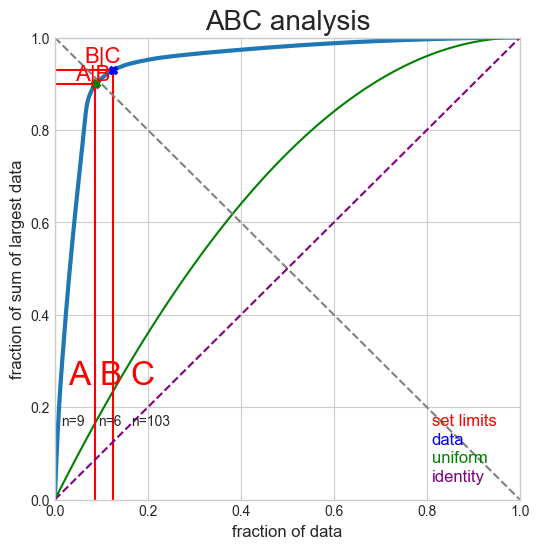

In [131]:
abc = abc_analysis(abc_analysis_df['Benefit per order'], True)

In [132]:
a_index = abc['Aind']
b_index = abc['Bind']
c_index = abc['Cind']

cond_list = [abc_analysis_df.index.isin(a_index),
             abc_analysis_df.index.isin(b_index),
             abc_analysis_df.index.isin(c_index)]

choice = ['A', 'B', 'C']

abc_analysis_df['abc'] = np.select(cond_list, choice)

In [136]:
abc_analysis_df[abc_analysis_df['abc'] =='B']

,Product Card Id,Order Item Quantity,Benefit per order,abc
103,1349,592,30289.80,B
104,1350,652,27178.10,B
105,1351,442,69656.81,B
107,1353,484,25531.17,B
109,1355,484,33443.01,B
117,1363,650,19102.85,B
